# Caso Práctico: Análisis y Forecast de Ventas

## Objetivo:
Evaluar la capacidad analítica para interpretar datos, detectar tendencias y proponer mejoras.  


## Material:
Un archivo de Excel con datos de ventas mensuales de tres productos en distintas regiones durante los últimos dos años.  


## Tareas:
1. Identificar Tendencias: Analizar la evolución de las ventas y resaltar patrones clave.
2. Realizar un Forecast: Usa el programa con el que te sientas más cómodo para proyectar las ventas futuras.
3. Detectar Insights y Áreas de Oportunidad: Escribir un breve análisis sobre qué está impulsando o afectando las ventas y qué estrategias podrían implementarse.


## Análisis exploratorio

In [51]:
# Lectura File
import pandas as pd

datos = pd.read_csv('data/Datos.csv')
datos.head()

,Mes,Producto,Región,Ventas
0,2022-01,Producto A,Norte,152
1,2022-01,Producto A,Centro,485
2,2022-01,Producto A,Sur,398
3,2022-01,Producto B,Norte,320
4,2022-01,Producto B,Centro,156


In [52]:
# Tipos de datos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Mes       216 non-null    object
 1   Producto  216 non-null    object
 2   Región    216 non-null    object
 3   Ventas    216 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.9+ KB


In [53]:
# Formato tipo de datos adecuado para analisis 
# Formato fecha (año-mes)
datos["Mes"] = pd.to_datetime(datos["Mes"], format="%Y-%m")

# Ajuste nombre
datos.rename(columns={'Región':'Region'}, inplace=True)

# Convertir "Ventas" a float
datos["Ventas"] = datos["Ventas"].astype(float)

datos.head()

,Mes,Producto,Region,Ventas
0,2022-01-01,Producto A,Norte,152.0
1,2022-01-01,Producto A,Centro,485.0
2,2022-01-01,Producto A,Sur,398.0
3,2022-01-01,Producto B,Norte,320.0
4,2022-01-01,Producto B,Centro,156.0


In [54]:
# Cantidad de valores por mes
datos['Mes'].value_counts().sort_index()

Mes
2022-01-01    9
2022-02-01    9
2022-03-01    9
2022-04-01    9
2022-05-01    9
2022-06-01    9
2022-07-01    9
2022-08-01    9
2022-09-01    9
2022-10-01    9
2022-11-01    9
2022-12-01    9
2023-01-01    9
2023-02-01    9
2023-03-01    9
2023-04-01    9
2023-05-01    9
2023-06-01    9
2023-07-01    9
2023-08-01    9
2023-09-01    9
2023-10-01    9
2023-11-01    9
2023-12-01    9
Name: count, dtype: int64

In [55]:
# Valores posibles en Producto
datos['Producto'].value_counts()

Producto
Producto A    72
Producto B    72
Producto C    72
Name: count, dtype: int64

In [56]:
# Valores posibles en Region
datos['Region'].value_counts()

Region
Norte     72
Centro    72
Sur       72
Name: count, dtype: int64

Contamos con 2 años de información  
3 productos diferentes y 3 Regiones diferentes

In [57]:
# Estadisticas descriptivas rapidas de ventas
datos['Ventas'].describe()

count    216.000000
mean     273.777778
std      129.609204
min       51.000000
25%      156.750000
50%      278.000000
75%      389.000000
max      498.000000
Name: Ventas, dtype: float64

### Tendencia general

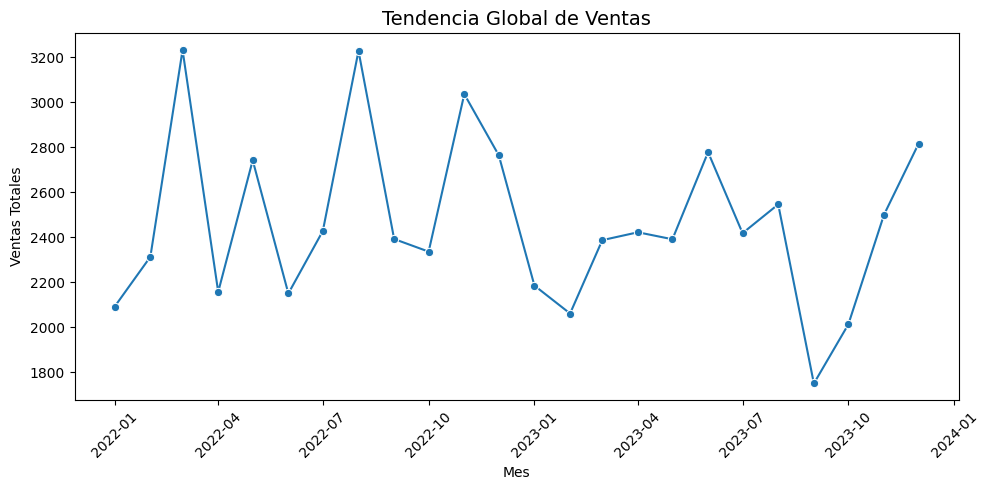

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

ventas_mensuales = datos.groupby("Mes", as_index=False)["Ventas"].sum()

# Crear gráfica de línea
plt.figure(figsize=(10,5))
sns.lineplot(data=ventas_mensuales, x="Mes", y="Ventas", marker="o")

plt.title("Tendencia Global de Ventas", fontsize=14)
plt.xlabel("Mes")
plt.ylabel("Ventas Totales")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('imagenes/tendencia_global.png', dpi=300)
plt.show()

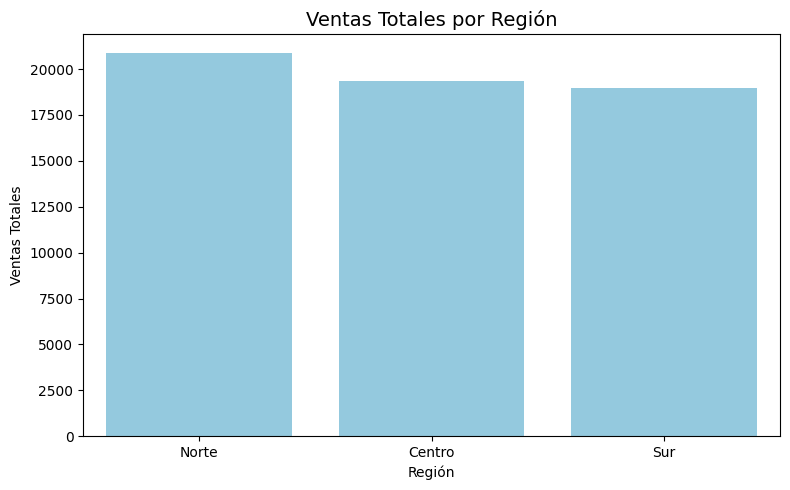

In [60]:
# Ventas totales por Región
plt.figure(figsize=(8,5))
sns.barplot(data=datos, x="Region", y="Ventas", estimator="sum", errorbar=None, color="skyblue")
plt.title("Ventas Totales por Región", fontsize=14)
plt.xlabel("Región")
plt.ylabel("Ventas Totales")
plt.tight_layout()
plt.savefig('imagenes/Ventas_Region.png', dpi=300)
plt.show()


In [61]:
datos.groupby('Region')['Ventas'].describe()

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Centro,72.0,268.611111,129.972755,58.0,166.75,260.0,380.75,495.0
Norte,72.0,289.611111,134.957328,51.0,179.50,307.0,398.50,498.0
Sur,72.0,263.111111,123.958711,64.0,147.00,277.0,360.00,495.0


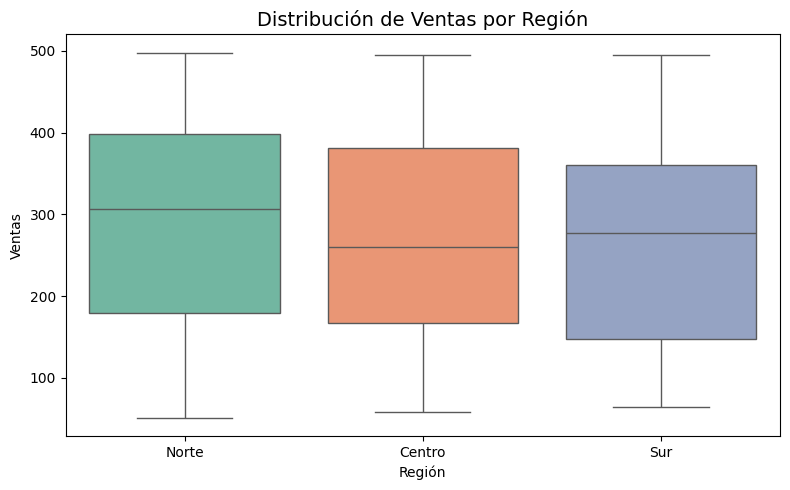

In [63]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=datos,
    x="Region", y="Ventas",
    hue="Region",         
    palette="Set2",
    legend=False
)
plt.title("Distribución de Ventas por Región", fontsize=14)
plt.xlabel("Región")
plt.ylabel("Ventas")
plt.tight_layout()
plt.savefig('imagenes/Boxplots_Region.png', dpi=300)
plt.show()

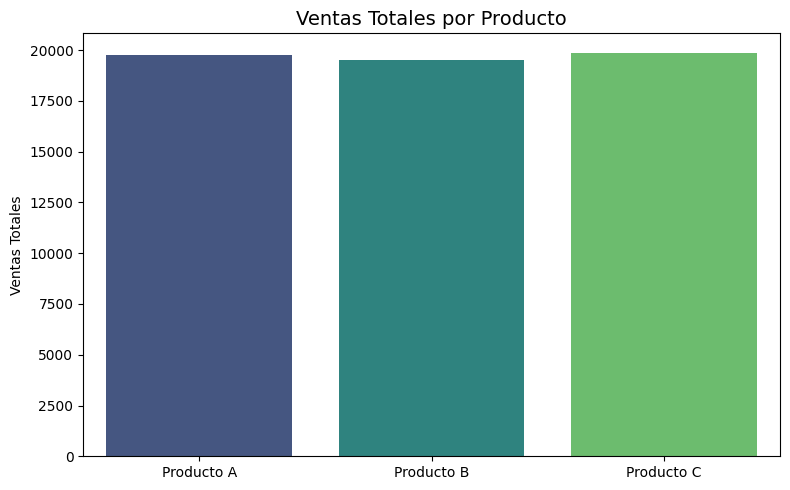

In [64]:
# Ventas totales por producto
plt.figure(figsize=(8,5))
sns.barplot(data=datos, x="Producto", y="Ventas", estimator="sum", errorbar=None, hue="Producto", palette="viridis",legend=False)
plt.title("Ventas Totales por Producto", fontsize=14)
plt.xlabel("")
plt.ylabel("Ventas Totales")
plt.tight_layout()
plt.savefig('imagenes/Ventas_Producto.png', dpi=300)
plt.show()

In [65]:
datos.groupby('Producto')['Ventas'].describe()

,count,mean,std,min,25%,50%,75%,max
Producto,,,,,,,,
Producto A,72.0,274.625000,115.088752,58.0,189.00,280.0,360.0,495.0
Producto B,72.0,271.236111,137.886000,54.0,143.00,275.5,398.5,495.0
Producto C,72.0,275.472222,136.384293,51.0,161.75,271.0,395.5,498.0


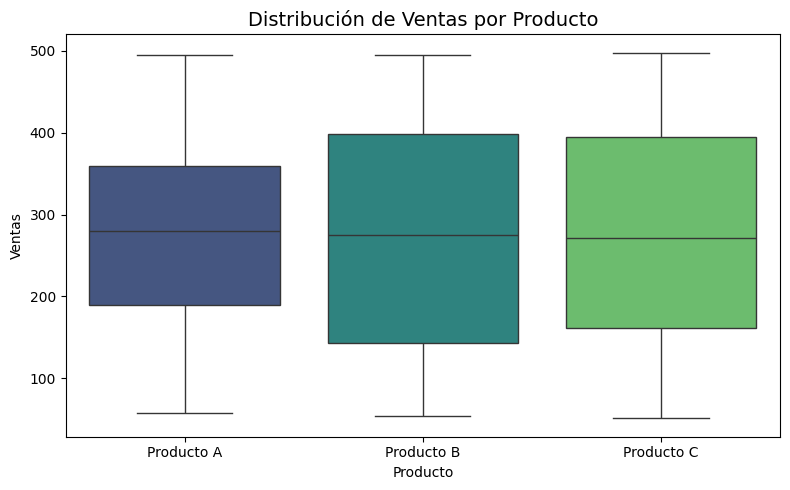

In [66]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=datos,
    x="Producto", y="Ventas",
    hue="Producto",
    palette="viridis",
    legend=False
)
plt.title("Distribución de Ventas por Producto", fontsize=14)
plt.xlabel("Producto")
plt.ylabel("Ventas")
plt.tight_layout()
plt.savefig('imagenes/Boxplots_Productos.png', dpi=300)
plt.show()

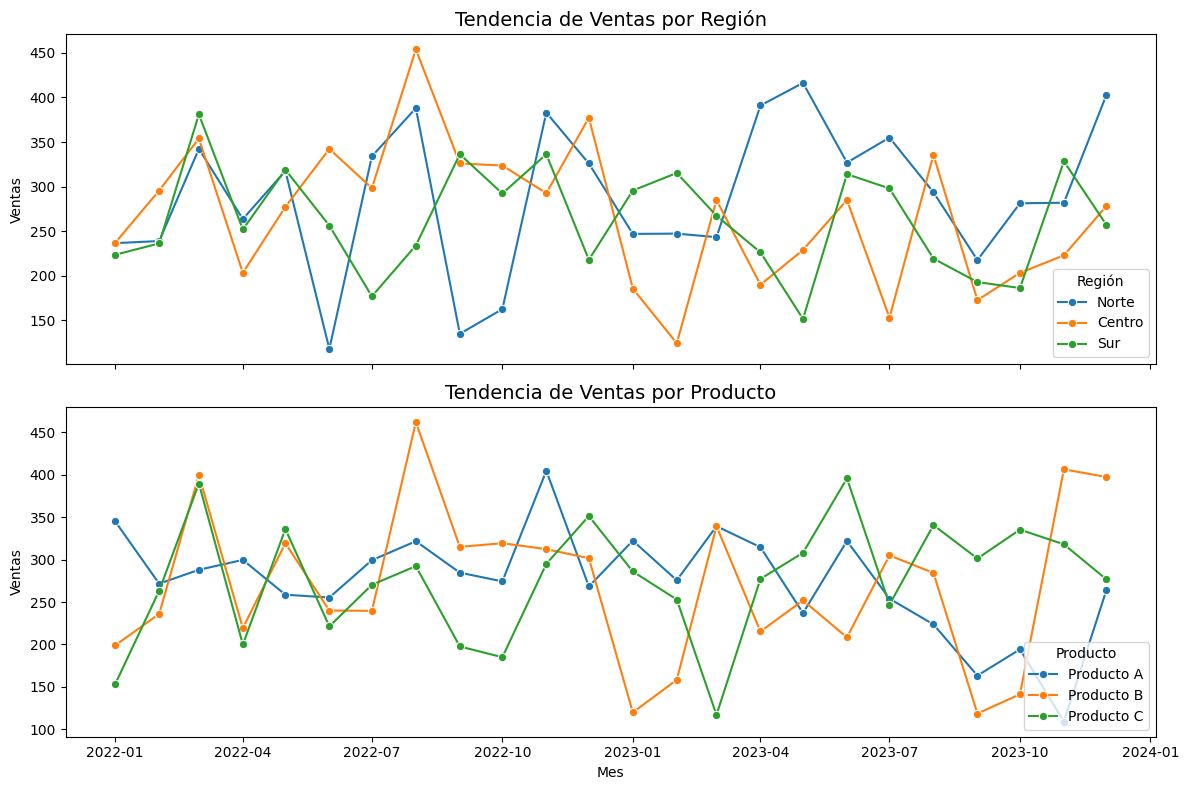

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

sns.lineplot(
    data=datos,
    x="Mes", y="Ventas",
    hue="Region",
    marker="o",
    errorbar=None,   
    ax=axes[0]
)
axes[0].set_title("Tendencia de Ventas por Región", fontsize=14)
axes[0].set_xlabel("")
axes[0].set_ylabel("Ventas")
axes[0].legend(title="Región", loc="lower right")

sns.lineplot(
    data=datos,
    x="Mes", y="Ventas",
    hue="Producto",
    marker="o",
    errorbar=None,   
    ax=axes[1]
)
axes[1].set_title("Tendencia de Ventas por Producto", fontsize=14)
axes[1].set_xlabel("Mes")
axes[1].set_ylabel("Ventas")
axes[1].legend(title="Producto", loc="lower right")

# Ajustar diseño
plt.tight_layout()
plt.show()

## Pruebas Estadisticas

In [68]:
from scipy.stats import f_oneway

# ANOVA por Región
grupo_region = [datos.loc[datos["Region"]==r, "Ventas"] for r in datos["Region"].unique()]
anova_region = f_oneway(*grupo_region)
print("ANOVA por Región:", anova_region)

# ANOVA por Producto
grupo_producto = [datos.loc[datos["Producto"]==p, "Ventas"] for p in datos["Producto"].unique()]
anova_producto = f_oneway(*grupo_producto)
print("ANOVA por Producto:", anova_producto)

ANOVA por Región: F_onewayResult(statistic=np.float64(0.8370158977616999), pvalue=np.float64(0.4344198356122455))
ANOVA por Producto: F_onewayResult(statistic=np.float64(0.021339374328477427), pvalue=np.float64(0.9788887916424093))


In [69]:
from scipy.stats import kruskal

# Kruskal-Wallis por Región
kruskal_region = kruskal(*grupo_region)
print("Kruskal-Wallis por Región:", kruskal_region)

# Kruskal-Wallis por Producto
kruskal_producto = kruskal(*grupo_producto)
print("Kruskal-Wallis por Producto:", kruskal_producto)

Kruskal-Wallis por Región: KruskalResult(statistic=np.float64(1.4867437323533794), pvalue=np.float64(0.4755078604698808))
Kruskal-Wallis por Producto: KruskalResult(statistic=np.float64(0.04193006382461093), pvalue=np.float64(0.9792532065827702))


In [70]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

modelo = ols("Ventas ~ C(Region) + C(Producto) + C(Region):C(Producto)", data=datos).fit()
anova = sm.stats.anova_lm(modelo, typ=2)
print(anova)

                             sum_sq     df         F    PR(>F)
C(Region)              2.816400e+04    2.0  0.841051  0.432725
C(Producto)            7.235278e+02    2.0  0.021606  0.978628
C(Region):C(Producto)  1.169311e+05    4.0  1.745935  0.141185
Residual               3.465869e+06  207.0       NaN       NaN


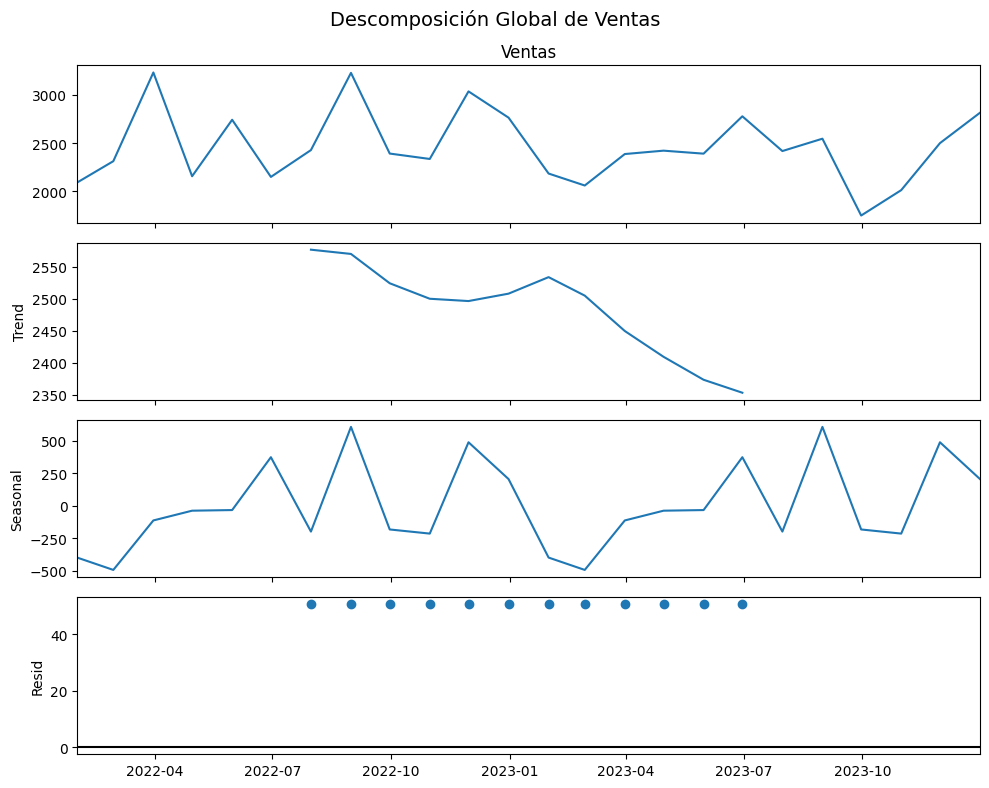

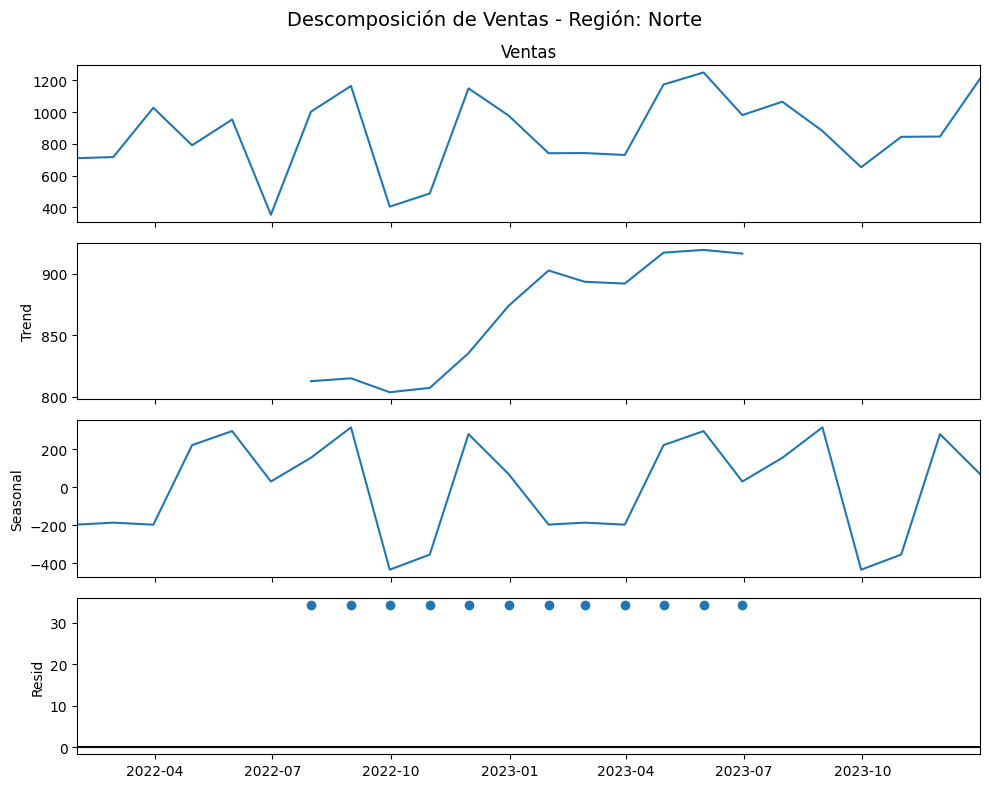

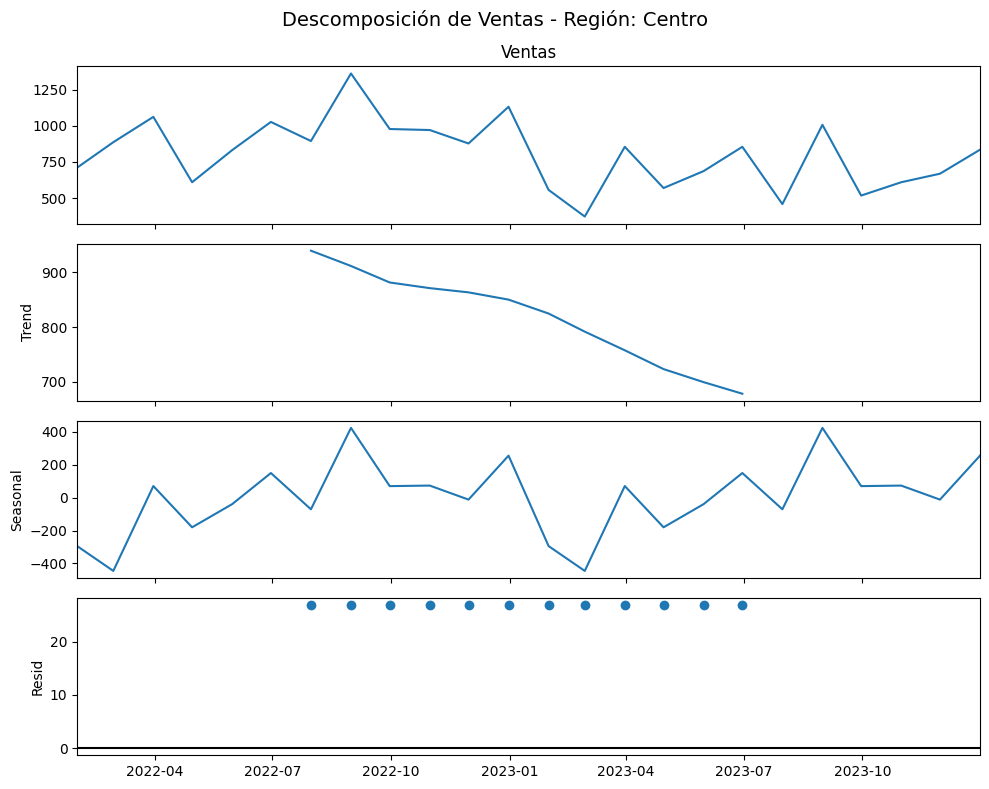

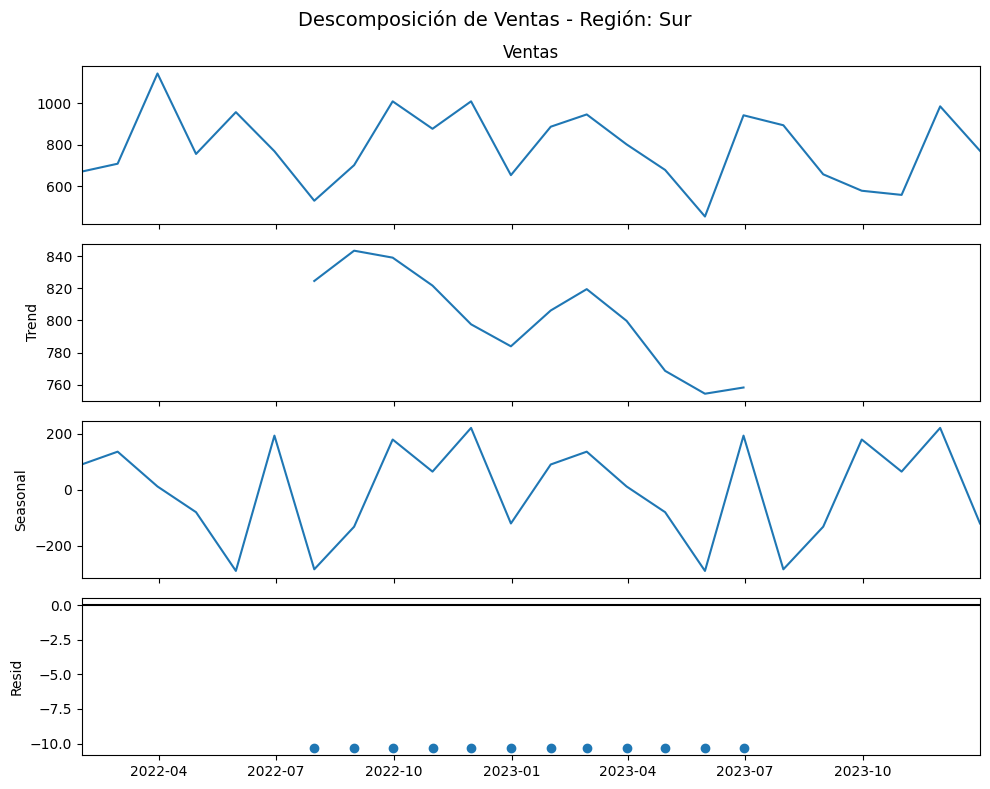

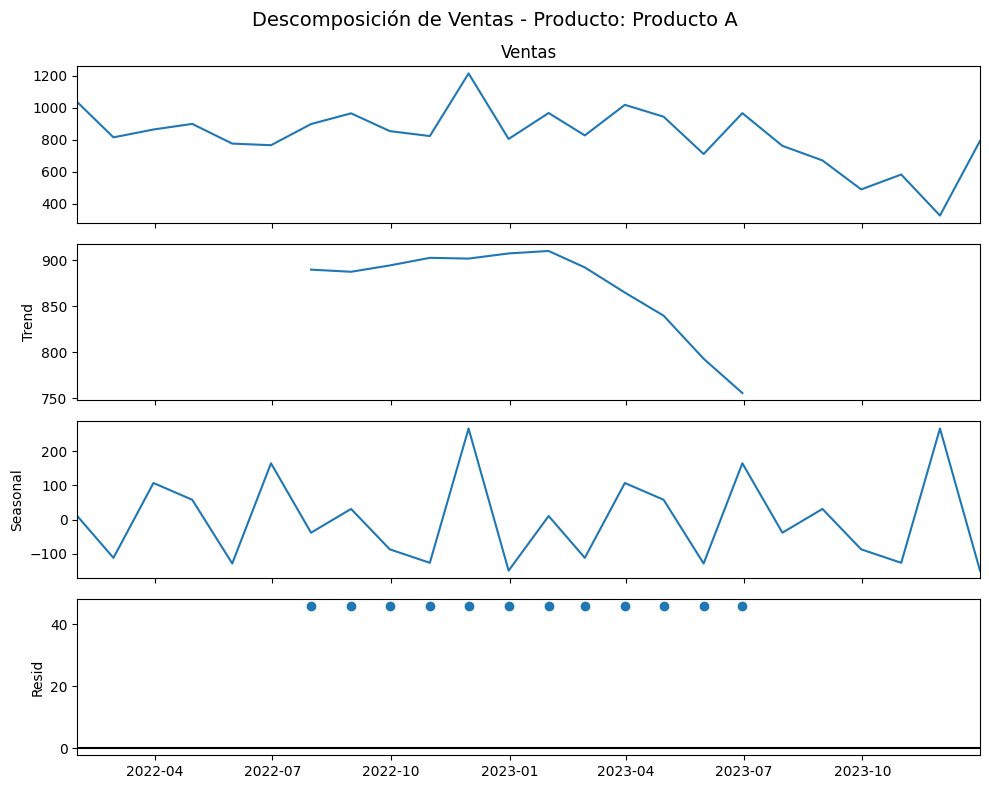

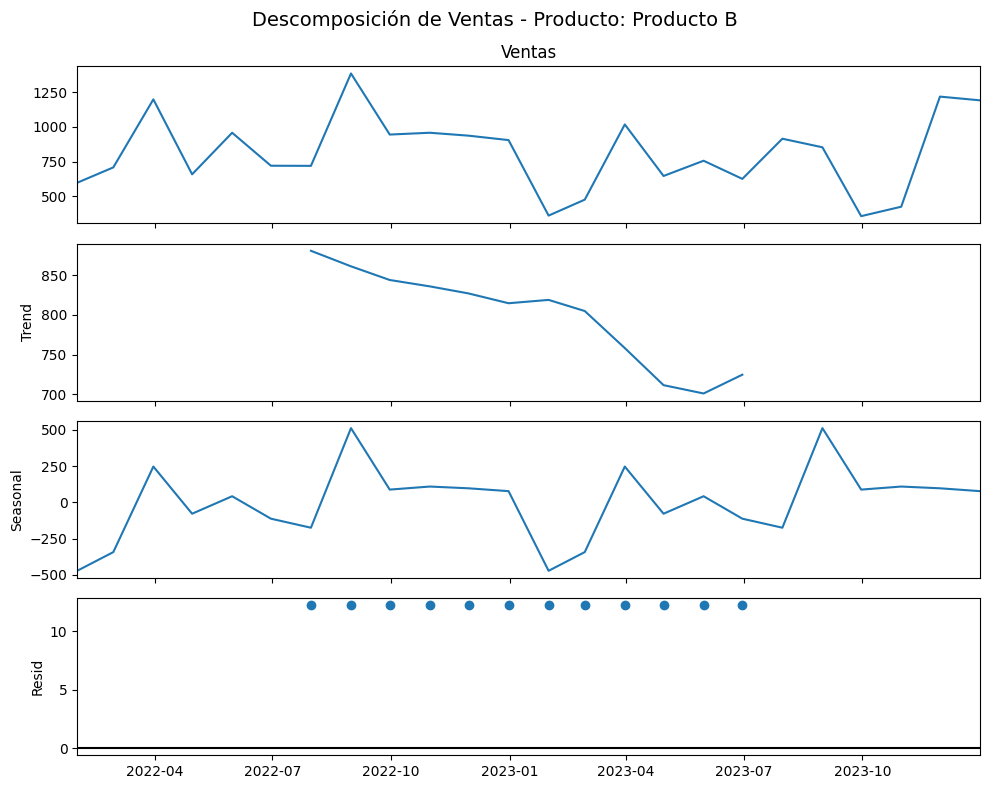

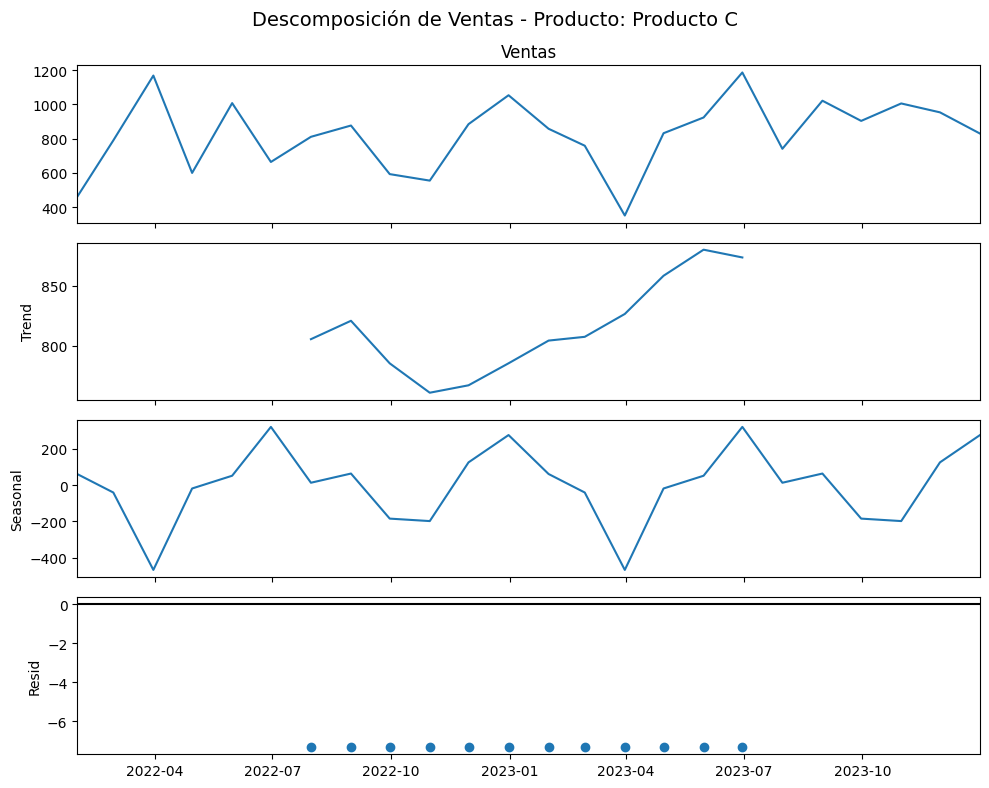

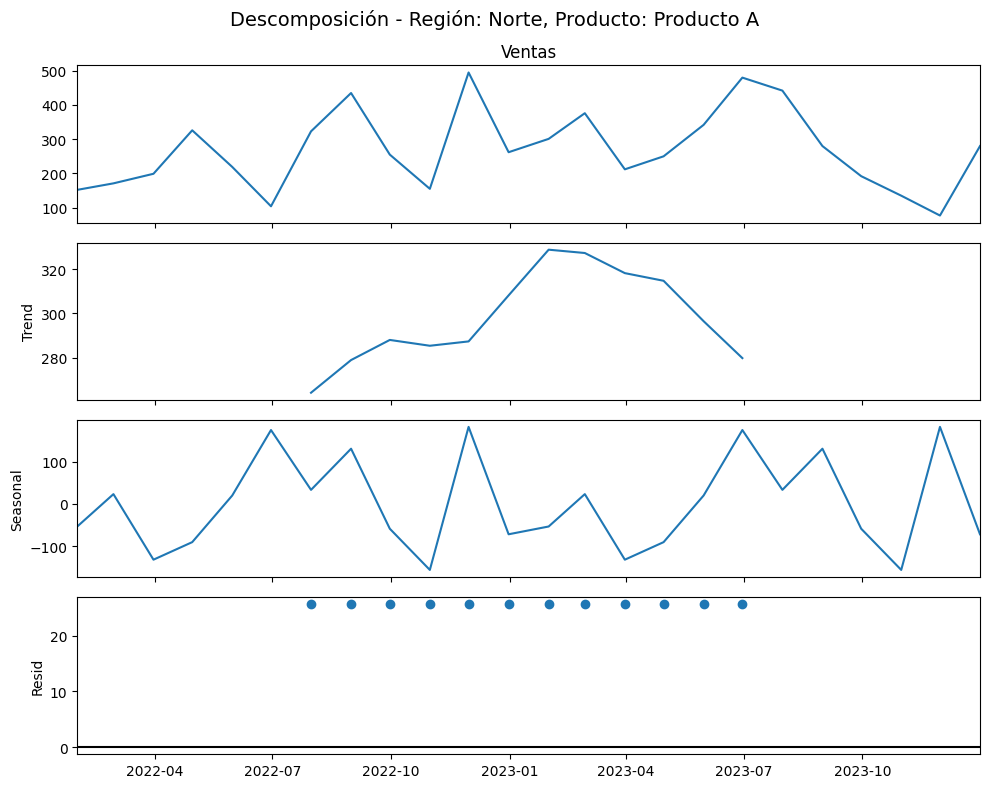

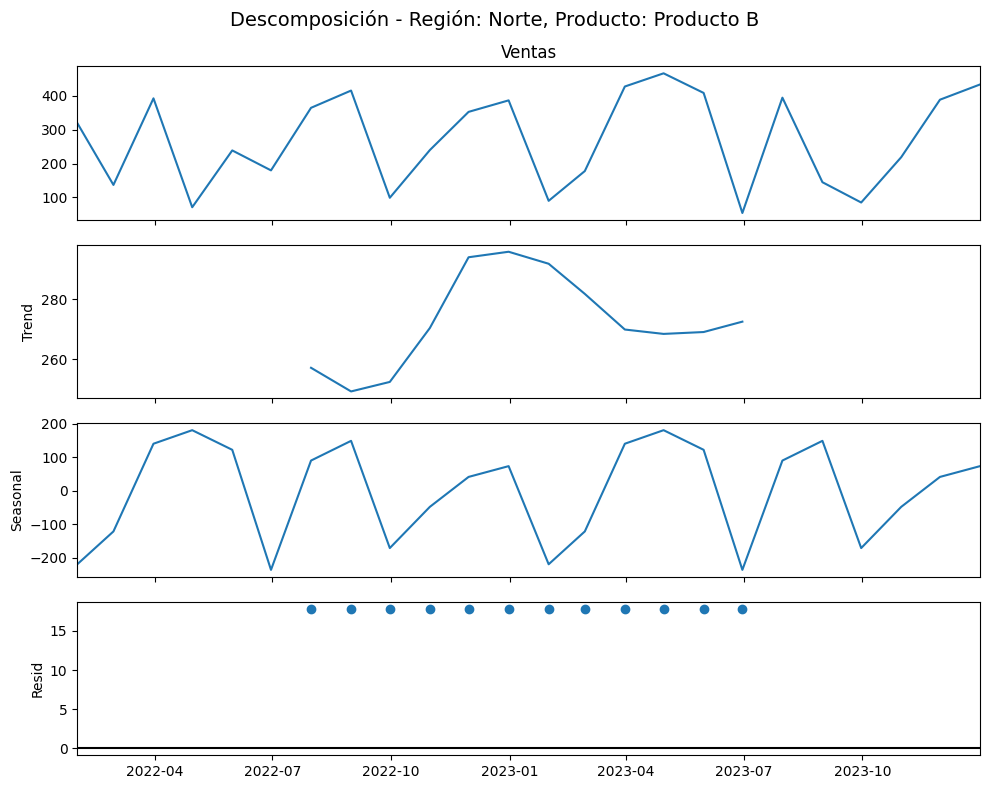

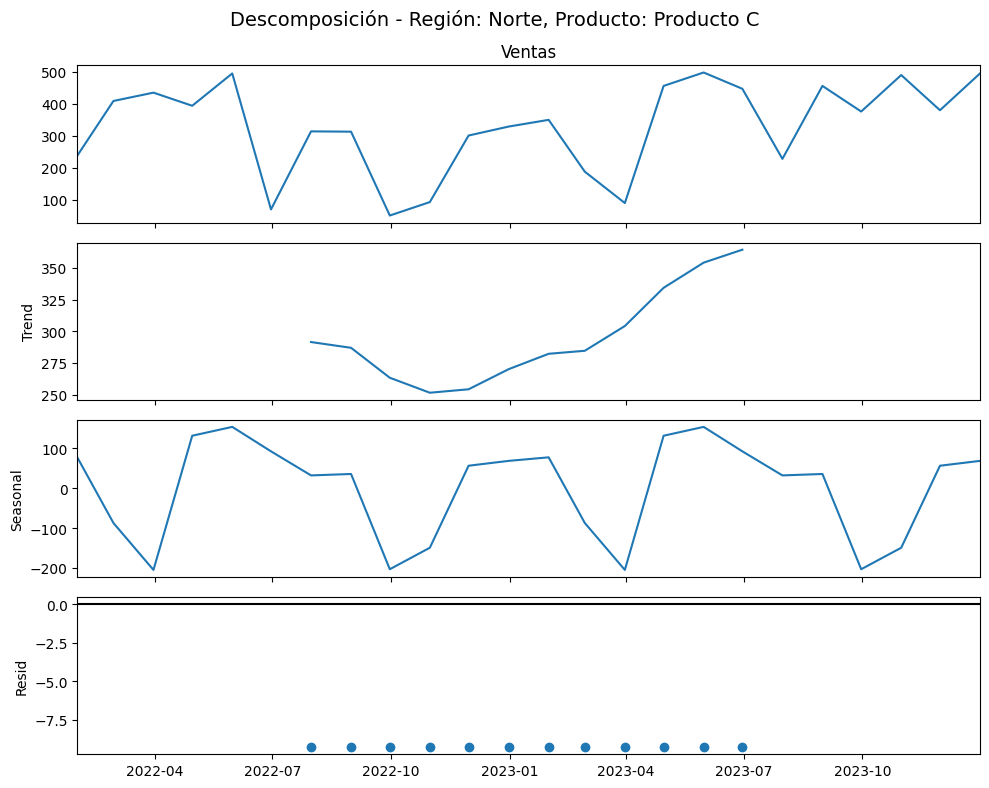

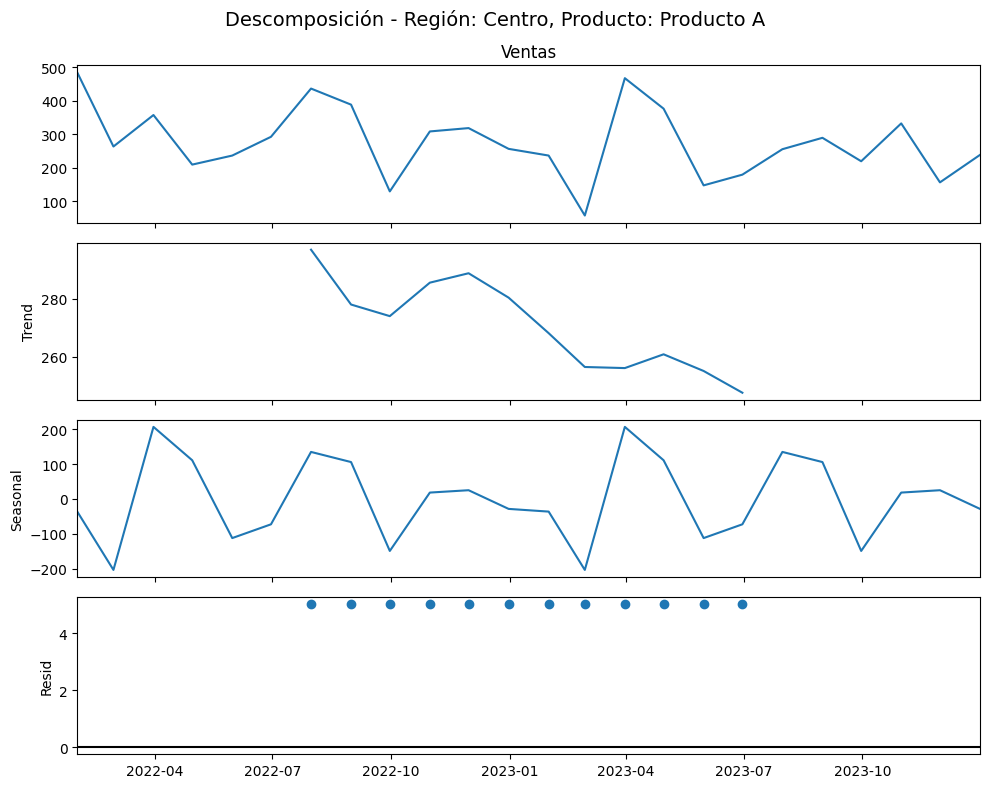

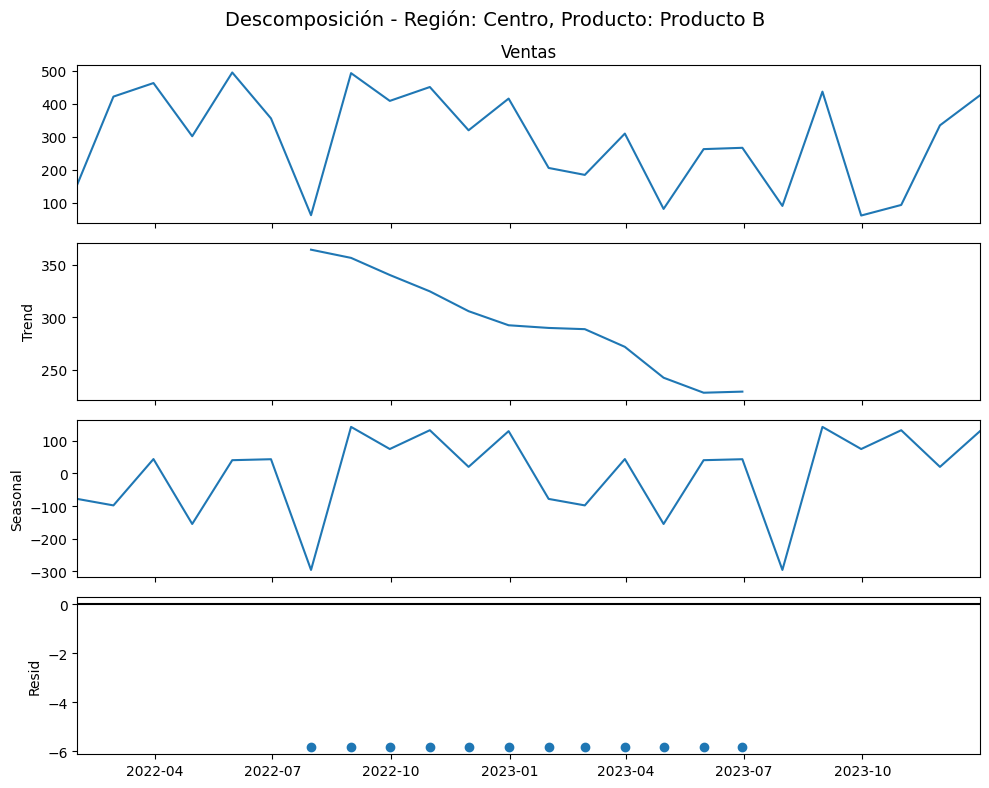

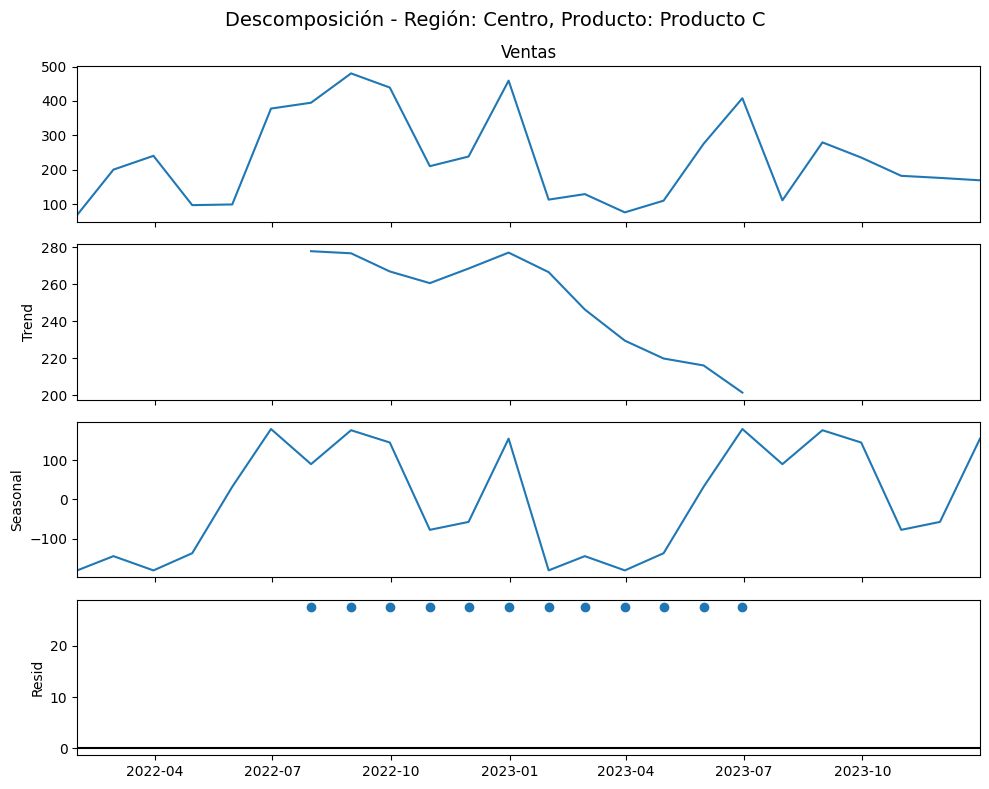

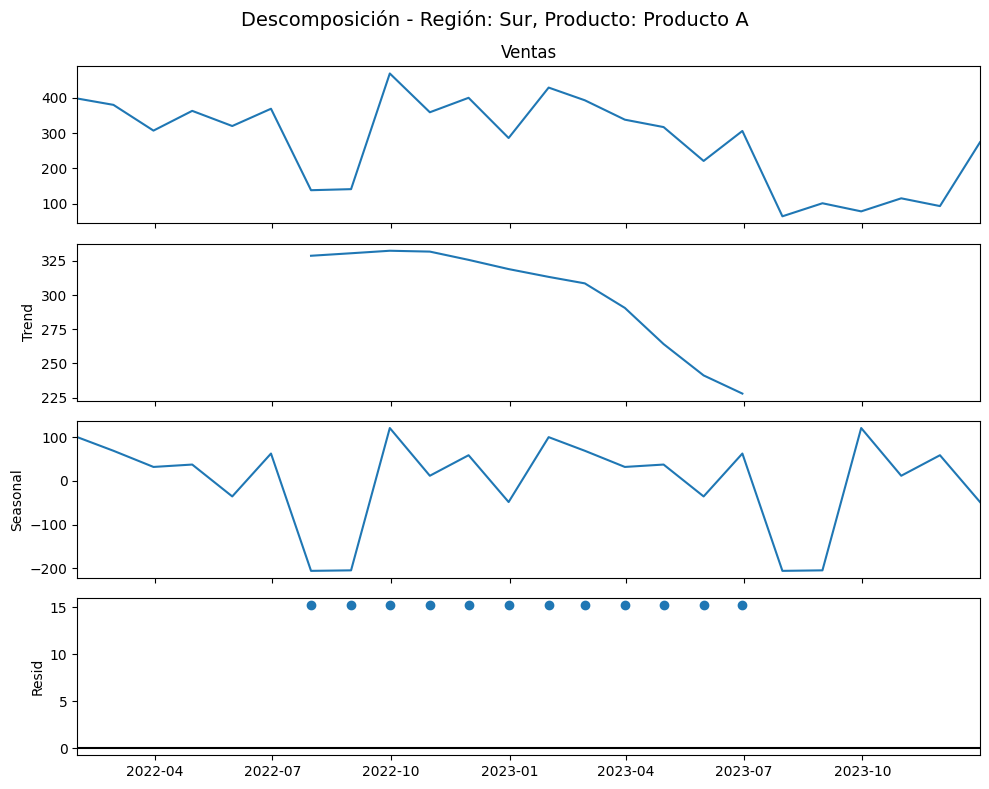

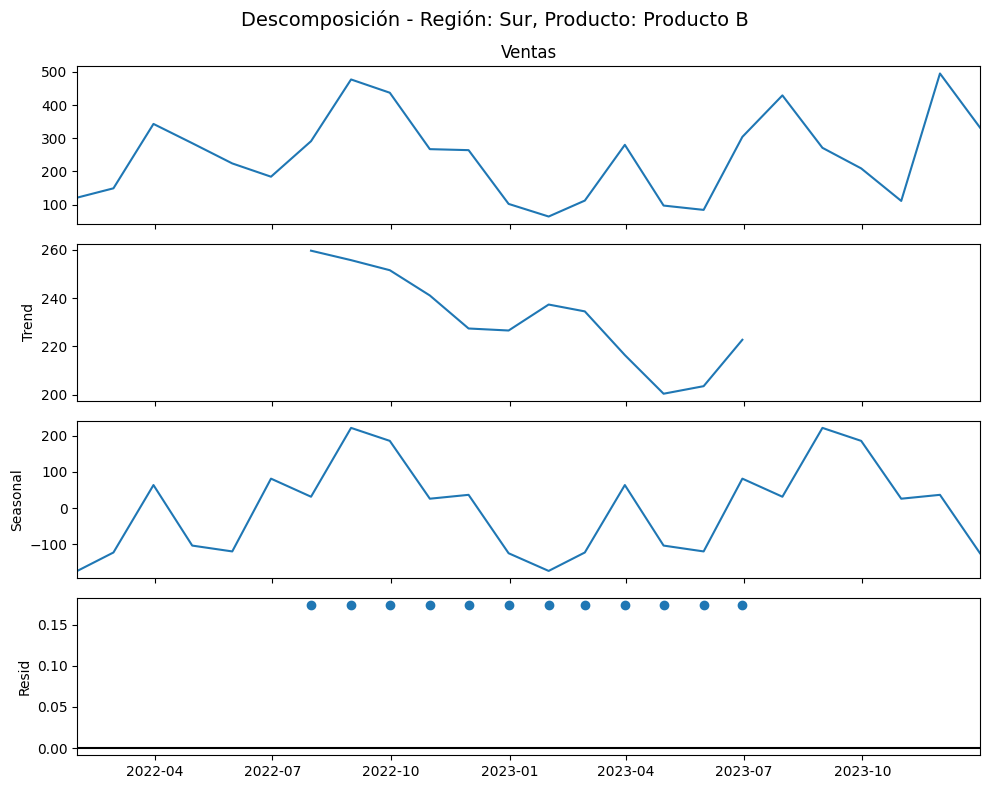

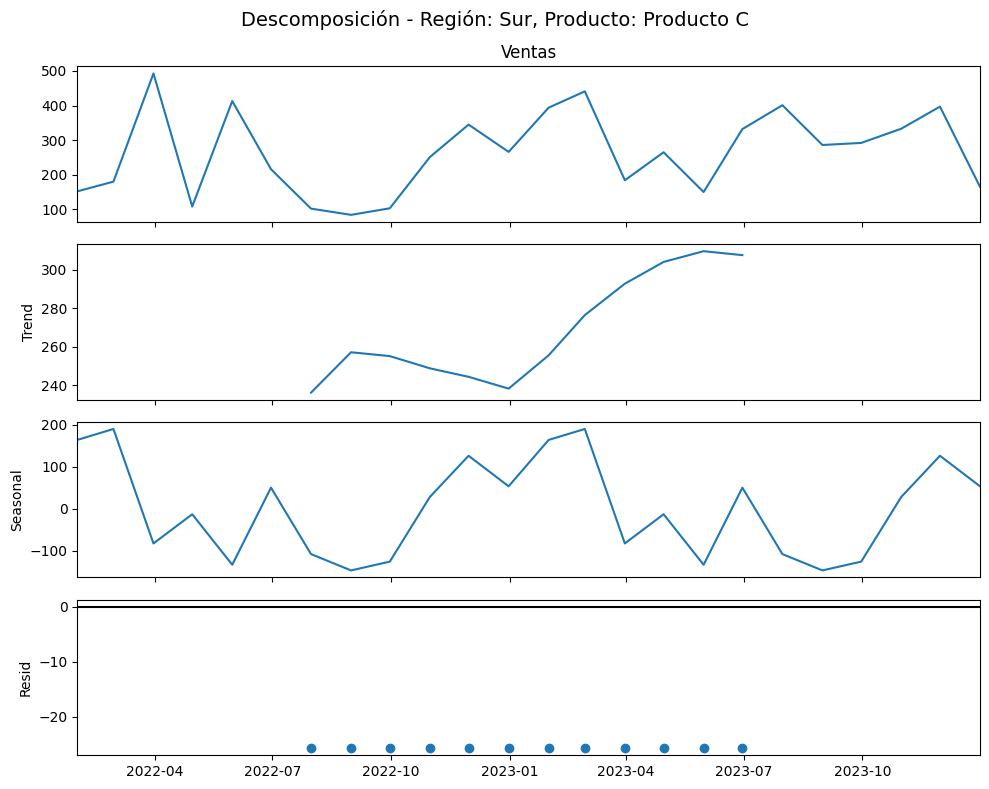

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")


# Asegúrate que la columna Mes sea el índice de la serie
datos = datos.set_index("Mes").sort_index()

# --- 1. Serie Global ---
serie_global = datos["Ventas"].resample("M").sum()

descomp_global = seasonal_decompose(serie_global, model="additive", period=12)

plt.rcParams.update({"figure.figsize": (10,8)})
descomp_global.plot()
plt.suptitle("Descomposición Global de Ventas", fontsize=14)
plt.tight_layout()
plt.show()

# --- 2. Por Región ---
for region in datos["Region"].unique():
    serie_region = datos[datos["Region"] == region]["Ventas"].resample("M").sum()
    descomp = seasonal_decompose(serie_region, model="additive", period=12)
    descomp.plot()
    plt.suptitle(f"Descomposición de Ventas - Región: {region}", fontsize=14)
    plt.tight_layout()
    plt.show()

# --- 3. Por Producto ---
for producto in datos["Producto"].unique():
    serie_producto = datos[datos["Producto"] == producto]["Ventas"].resample("M").sum()
    descomp = seasonal_decompose(serie_producto, model="additive", period=12)
    descomp.plot()
    plt.suptitle(f"Descomposición de Ventas - Producto: {producto}", fontsize=14)
    plt.tight_layout()
    plt.show()

# --- 4. Por Región * Producto ---
for region in datos["Region"].unique():
    for producto in datos["Producto"].unique():
        serie_sub = datos[(datos["Region"] == region) & (datos["Producto"] == producto)]["Ventas"].resample("M").sum()
        
        # Evitar error si la serie está vacía o con pocos datos
        if len(serie_sub) > 12:  
            descomp = seasonal_decompose(serie_sub, model="additive", period=12)
            descomp.plot()
            plt.suptitle(f"Descomposición - Región: {region}, Producto: {producto}", fontsize=14)
            plt.tight_layout()
            plt.show()

Aunque las pruebas estadisticas no dieron diferencias signficativas entre Productos, Region y la interacción de los mismos, al realizar una Descomposición de estacionalidad de las series de tiempo se muestra como tienen comportamientos diferentes. Mismo que se logra apreciar en algunos boxplots al ver la distribucción de los datos. Por lo cual, se propone un modelo que considere ambos efectos. 


## Modelo Holt-Winters

In [50]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

# Ocultar todos los warnings
warnings.filterwarnings("ignore")

# Copiar dataset
df = datos.copy()

# Crear columna de interacción
df['Interaccion'] = df['Producto'] + ' - ' + df['Region']
combinaciones = df['Interaccion'].unique()

# Crear carpeta de imágenes si no existe
os.makedirs('imagenes', exist_ok=True)

# DataFrame para guardar todos los pronósticos
pronosticos_df = pd.DataFrame(columns=['Mes', 'Producto', 'Region', 'VentaEstimada', 'IntervaloBajo', 'IntervaloAlto'])

# Iterar sobre cada combinación Producto-Region
for comb in combinaciones:
    print(f"Procesando: {comb}")
    df_comb = df[df['Interaccion'] == comb].copy()
    ts_comb = df_comb['Ventas']
    
    try:
        # Ajustar Holt-Winters con tendencia y estacionalidad aditiva
        model = ExponentialSmoothing(ts_comb, trend='add', seasonal='add', seasonal_periods=12)
        fit_model = model.fit()
        
        # Pronóstico a 3 Meses
        forecast = fit_model.forecast(steps=3)
        
        # Intervalo de confianza aproximado (+/-5%)
        forecast_ci = pd.DataFrame({
            'IntervaloBajo': forecast * 0.95,
            'IntervaloAlto': forecast * 1.05
        })
        
        # Guardar en DataFrame
        temp_df = pd.DataFrame({
            'Mes': forecast.index.to_period('M').strftime('%Y-%m'),
            'Producto': df_comb['Producto'].iloc[0],
            'Region': df_comb['Region'].iloc[0],
            'VentaEstimada': forecast.values,
            'IntervaloBajo': forecast_ci['IntervaloBajo'].values,
            'IntervaloAlto': forecast_ci['IntervaloAlto'].values
        })
        pronosticos_df = pd.concat([pronosticos_df, temp_df], ignore_index=True)
        
        # Graficar y guardar imagen
        plt.figure(figsize=(10,6))
        ts_comb.plot(label='Ventas Históricas')
        forecast.plot(label='Pronóstico a 3 Meses', color='red')

        # Línea punteada para unir último histórico con primer pronóstico
        plt.plot([ts_comb.index[-1], forecast.index[0]],
                [ts_comb.iloc[-1], forecast.iloc[0]],
                linestyle='--', color='red')
        
        plt.fill_between(forecast.index, forecast_ci['IntervaloBajo'], forecast_ci['IntervaloAlto'],
                        color='r', alpha=0.25, label='Intervalo de Confianza (aprox. 5%)')
        plt.title(f'Pronóstico de Ventas para {comb}')
        plt.xlabel('Fecha')
        plt.ylabel('Ventas')
        plt.legend()
        plt.grid(True)
        
        # Guardar imagen
        producto = df_comb['Producto'].iloc[0].replace(" ", "")
        region = df_comb['Region'].iloc[0].replace(" ", "")
        plt.savefig(f'imagenes/{producto}{region}Estimacion.png')
        plt.close()
        
    except Exception as e:
        print(f"No se pudo ajustar el modelo para {comb}. Error: {e}")
        continue

# --- Pronóstico global ---
print("\nGenerando pronóstico global...")
ts_global = df.groupby('Mes')['Ventas'].sum()
try:
    model_global = ExponentialSmoothing(ts_global, trend='add', seasonal='add', seasonal_periods=12)
    fit_global = model_global.fit()
    
    forecast_global = fit_global.forecast(steps=3)
    forecast_ci_global = pd.DataFrame({
        'IntervaloBajo': forecast_global * 0.95,
        'IntervaloAlto': forecast_global * 1.05
    })
    
    # Guardar pronóstico global en DataFrame
    temp_global_df = pd.DataFrame({
        'Mes': forecast_global.index.to_period('M').strftime('%Y-%m'),
        'Producto': 'Global',
        'Region': 'Global',
        'VentaEstimada': forecast_global.values,
        'IntervaloBajo': forecast_ci_global['IntervaloBajo'].values,
        'IntervaloAlto': forecast_ci_global['IntervaloAlto'].values
    })
    pronosticos_df = pd.concat([pronosticos_df, temp_global_df], ignore_index=True)
    
    # Graficar y guardar imagen global
    plt.figure(figsize=(10,6))
    ts_global.plot(label='Ventas Históricas Globales')
    forecast_global.plot(label='Pronóstico Global a 3 Meses', color='red')
    
    # Línea punteada para unir último histórico con primer pronóstico global
    plt.plot([ts_global.index[-1], forecast_global.index[0]],
            [ts_global.iloc[-1], forecast_global.iloc[0]],
            linestyle='--', color='red')
    
    plt.fill_between(forecast_global.index, forecast_ci_global['IntervaloBajo'], forecast_ci_global['IntervaloAlto'],
                    color='r', alpha=0.25, label='Intervalo de Confianza (aprox. 5%)')
    plt.title('Pronóstico de Ventas Global')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas')
    plt.legend()
    plt.grid(True)
    plt.savefig('imagenes/PronosticoGlobalEstimacion.png')
    plt.close()
    
except Exception as e:
    print(f"No se pudo generar pronóstico global. Error: {e}")

# Mostrar los primeros registros del DataFrame final
print(pronosticos_df.head())

Procesando: Producto A - Norte
Procesando: Producto A - Centro
Procesando: Producto A - Sur
Procesando: Producto B - Norte
Procesando: Producto B - Centro
Procesando: Producto B - Sur
Procesando: Producto C - Norte
Procesando: Producto C - Centro
Procesando: Producto C - Sur

Generando pronóstico global...
       Mes    Producto  Region  VentaEstimada  IntervaloBajo  IntervaloAlto
0  2024-01  Producto A   Norte     260.335208     247.318447     273.351968
1  2024-02  Producto A   Norte     307.347713     291.980327     322.715098
2  2024-03  Producto A   Norte     239.366367     227.398048     251.334685
3  2024-01  Producto A  Centro     270.375618     256.856837     283.894399
4  2024-02  Producto A  Centro      70.373567      66.854888      73.892245
